# Übung 1: Berechnung einer absoluten Positionierung mit Code-Messungen

In [2]:
# Requirements 
# pip install git+https://github.com/GNSSpy-Project/gnsspy
# pip install pyunpack
# pip install georinex

import gnsspy as gp
import numpy as np
import georinex
import geopandas
import matplotlib.pyplot as plt
import math

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [3]:
# Dataimport
station = gp.read_obsFile("ONSA0320.11O")
ephemerides = georinex.load("G3_11032.PRE")

ONSA0320.11O exist in working directory | Reading...
Line 19 :                             4  4
Unexpected format between epochs! Line 20 is deleted!
Line 24 :                             4  4
Unexpected format between epochs! Line 25 is deleted!
Line 29 :                             4  4
Unexpected format between epochs! Line 30 is deleted!
Line 34 :                             4  4
Unexpected format between epochs! Line 35 is deleted!
Line 39 :                             4  4
Unexpected format between epochs! Line 40 is deleted!
Line 44 :                             4  4
Unexpected format between epochs! Line 45 is deleted!
Line 49 :                             4  4
Unexpected format between epochs! Line 50 is deleted!
Line 54 :                             4  4
Unexpected format between epochs! Line 55 is deleted!
Line 59 :                             4  4
Unexpected format between epochs! Line 60 is deleted!
Line 64 :                             4  4
Unexpected format between epoch

# a) Groundtrack

In [15]:
def calculateLatLong(earth_fixed_coords):
    lat = list()
    lon = list()

    for x, y, z in earth_fixed_coords:
        lat.append(math.degrees(math.atan2(z, math.sqrt(x**2 + y**2)))) 
        lon.append(math.degrees(math.atan2(y, x)))

    return lat, lon

def plotGroundTrack(name, desc, lat, lon):
    countries = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

    countries.plot(color = "grey")
    plt.scatter(lon, lat, color = "purple")

    minimum = round(min(lat), 4)
    maximum = round(max(lat), 4)

    plt.grid()
    plt.ylim(-90,90)
    plt.xlim(-180,180)
    plt.title(name + " " + desc)
    plt.figtext(0.5, 0.15, "Minimale Breite: " + str(minimum) + "° / maximale Breite: " + str(maximum) + "°", ha = "center", fontsize = 9, style = "italic")
    plt.show()
    #plt.savefig("Export/" + name + "_" + desc + '.png')

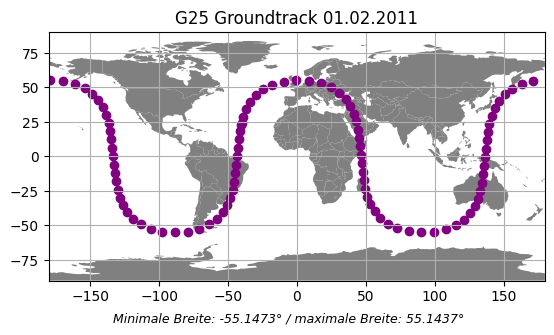

In [16]:
# Plot Groundtrack
lat, lon = calculateLatLong(ephemerides.sel(sv="G25").position)
plotGroundTrack("G25", "Groundtrack 01.02.2011", lat, lon)

Die Umlaufzeit beträgt ungefähr 12h. Dies kann man an der Anzahl an Beobachtungen (96, alle 15 Minuten eine über 24h) und der Bodenspur ableiten. Der Satellit macht von -180 bis 0 Grad ca. einen Umlauf, und dann nochmals für 0 bis 180 Grad. Weil nur 24h aufgezeichnet wurde, kann man darauf schliessen, dass der Satellit zwei Umläufe gemacht hat.

# b) Satellitenpositionen

In [6]:
# Load slice
ephemerides_interval = georinex.load("G3_11032.PRE", tlim=['2011-01-02T00:00', '2011-01-02T01:00']) # this tlim is not working
ephemerides_interval.sel(sv="G25")

# Consts
omega_e = 7.292115e-5 #s^-1
c = 299792458 #m/s

# Functions
def calculateSatPos(earth_fixed_coords, sat_velocities):
    earth_fixed_coords_si = earth_fixed_coords * 1000 # km to m
    sat_velocities_si = sat_velocities / 10 # dm/s to m/s
    
    sat_coords = list()
    for i, coord in enumerate(earth_fixed_coords_si):
        tau = math.dist(np.array(station.approx_position), coord) / c
        sat_coords.append(np.array(coord).T - np.array( (sat_velocities_si[i] + (omega_e * np.array([-coord[1], coord[0], 0]))) * tau))
        if i == 3: break # sorry this is a hack because tlim does not work

    return np.array(sat_coords)

In [7]:
# Calculate positions
sat_coords_at_send = calculateSatPos(ephemerides_interval.sel(sv="G25").position, ephemerides_interval.sel(sv="G25").velocity)

print(sat_coords_at_send, "\nCorrections: \n", np.array(ephemerides_interval.sel(sv="G25").position[0:4] * 1000 - sat_coords_at_send))

[[ 18619309.354 -15884993.138  10299699.614]
 [ 18131149.077 -14641084.755  12725495.939]
 [ 17588720.663 -13139931.118  14932097.457]
 [ 17031860.251 -11396433.550  16881479.002]] 
Corrections: 
 [[ 50.886  199.651  215.667]
 [ 36.655  214.201  194.036]
 [ 25.014  227.095  170.245]
 [ 15.734  238.110  144.779]]


# c) Zenitwinkel & troposphärische Verzögerung

In [17]:
# Coords of station in lat, lon
x, y, z = station.approx_position
lat_s = math.atan2(z, math.sqrt(x**2 + y**2))
lon_s = math.atan2(y, x)

print(lat_s, lon_s)
print(math.degrees(lat_s), math.degrees(lon_s)) # in IGS08 (is weird, not correct on ONSA)

0.9986836835138355 0.2081394688589602
57.22036013392161 11.925513115713049


In [9]:
# Rotation matrices
def ry(a): return np.matrix([[np.cos(a), 0, np.sin(a)], [0, 1, 0], [-np.sin(a), 0, np.cos(a)]])
def rz(a): return np.matrix([[np.cos(a), -np.sin(a), 0], [np.sin(a), np.cos(a), 0], [0, 0, 1]])
r2 = ry((math.pi / 2) - lat_s)
r3 = rz(lon_s)

# Calculate N, E, U
n, e, u = list(), list(), list()
for coords in sat_coords_at_send:
    topo_coords = (r2 @ r3 @ (coords - station.approx_position).T)
    #print(topo_coords)
    n.append(-topo_coords[0,0])
    e.append(topo_coords[0,1])
    u.append(topo_coords[0,2])

# Zenitwinkel
Zn = list()
for i in range(4):
    Zn.append(math.degrees(math.atan2(math.sqrt(n[i]**2 + e[i]), u[i])))

Zn = np.array(Zn)
print(Zn)

[ 107.683  100.059  93.041  86.773]


In [12]:
# Tropospheric delay
def calculateTropDelay(angle):
    return 2.4 / math.cos(math.radians(angle))

vfunc = np.vectorize(calculateTropDelay)
print(vfunc(Zn))

[-7.901 -13.741 -45.235  42.641]


# d) Relativistische Effekte

In [14]:
# Relativistic delay
def calculateRelativistics(coord, velocity):
    return 2 * coord * velocity / c

relativistic = np.vectorize(calculateRelativistics)
print(relativistic(sat_coords_at_send, ephemerides_interval.sel(sv="G25").velocity[0:4] / 10))

[[-61.764 -130.992  192.525]
 [-70.164 -149.151  219.110]
 [-72.510 -158.326  230.662]
 [-69.602 -156.926  226.387]]
